In [682]:
# Install (if needed) and load modern packages
# install.packages(c("readr","dplyr","tsibble","fable","fabletools","lubridate"))
library(readr)
library(dplyr)
library(tsibble)
library(fable)
library(fabletools)
library(lubridate)

# 1) Load CSV
df_raw <- read_csv("data/Ischemic_death_rate_both_onlycountry.csv",
                   show_col_types = FALSE)

# 2) Keep required columns, drop sex (constant), standardize names
df <- df_raw |>
  transmute(
    country = .data$location,
    year    = as.integer(.data$year),
    Ischemic_DR = as.numeric(.data$Ischemic_DR)
  )

# 3) Minimal QC: remove duplicates, drop rows with missing or invalid target
df <- df |>
  distinct(country, year, .keep_all = TRUE) |>
  filter(!is.na(Ischemic_DR), Ischemic_DR >= 0)

# 4) Create a tsibble (keyed by country, indexed by year), ensure regularity
ts <- df |>
  as_tsibble(key = country, index = year)

# Optional: check gaps per country (informative; does not alter data)
tsibble::has_gaps(ts) # logical per key; keep data as-is for GBD provenance


New names:
• `` -> `...1`


In [683]:
library(dplyr)
library(tsibble)
library(fable)
library(fabletools)

assess_years <- 5L

# Identify last k years per country as test set (work in tibble where appropriate)
last_years <- ts |>
  as_tibble() |>
  group_by(country) |>
  mutate(rank_year = rank(year), max_rank = max(rank(year))) |>
  ungroup() |>
  filter(max_rank - rank_year < assess_years) |>
  distinct(country, year)

# Split back into tsibbles using tibble joins, then re-tsibble explicitly
train <- ts |> anti_join(last_years, by = c("country","year"))
test  <- ts |> semi_join(last_years, by = c("country","year"))

# Fit baselines on training
fit_train <- train |>
  model(
    naive  = NAIVE(Ischemic_DR),
    drift  = RW(Ischemic_DR ~ drift()),
    linear = TSLM(Ischemic_DR ~ trend())
  )

# Forecast exactly the test timestamps per country
fc_test <- fit_train |>
  forecast(new_data = test)

# Accuracy per forecasted point, then convert to tibble immediately
acc_point <- fc_test |>
  accuracy(test) |>
  as_tibble()

# Aggregate to one row per country & model in tibble space
acc_by_cty_model <- acc_point |>
  group_by(country, .model) |>
  summarise(
    RMSE = mean(RMSE, na.rm = TRUE),
    MAE  = mean(MAE,  na.rm = TRUE),
    .groups = "drop"
  )

# Denominator for MASE: compute in tibble space using training data
denom <- train |>
  as_tibble() |>
  group_by(country) |>
  arrange(year, .by_group = TRUE) |>
  mutate(diff1 = Ischemic_DR - dplyr::lag(Ischemic_DR)) |>
  summarise(mad_naive = mean(abs(diff1), na.rm = TRUE), .groups = "drop")

# One-to-many-safe join: one denom per country
acc_joined <- acc_by_cty_model |>
  left_join(denom, by = "country")

# Compute robust MASE per country-model, then summarise across countries
acc_summary <- acc_joined |>
  mutate(MASE_robust = ifelse(!is.na(mad_naive) & mad_naive > 0, MAE / mad_naive, NA_real_)) |>
  group_by(.model) |>
  summarise(
    MASE_robust = mean(MASE_robust, na.rm = TRUE),
    RMSE        = mean(RMSE,        na.rm = TRUE),
    MAE         = mean(MAE,         na.rm = TRUE),
    n_countries = dplyr::n(),
    n_MASE      = sum(!is.na(MASE_robust)),
    .groups = "drop"
  ) |>
  arrange(coalesce(MASE_robust, RMSE, MAE))

acc_summary


In [684]:
# Split integrity
split_check <- list(
  train_max = train |> as_tibble() |> group_by(country) |> summarise(train_max = max(year), .groups = "drop"),
  test_min  = test  |> as_tibble() |> group_by(country) |> summarise(test_min  = min(year), test_n = dplyr::n(), .groups = "drop")
) |>
  (\(x) left_join(x$train_max, x$test_min, by = "country"))() |>
  mutate(leakage = train_max >= test_min)

split_check  # leakage should be FALSE; test_n <= assess_years

# Residual diagnostics (training fits)
aug_train <- fit_train |>
  augment() |>
  as_tibble()

lb <- aug_train |>
  group_by(country, .model) |>
  summarise(
    lb_pvalue = Box.test(.resid, lag = 8, type = "Ljung-Box", fitdf = 0)$p.value,
    resid_sd  = sd(.resid, na.rm = TRUE),
    resid_me  = mean(.resid, na.rm = TRUE),
    .groups = "drop"
  )

lb  # Expect small p-values for naive/drift; record for context

# Robust MASE coverage
coverage <- acc_summary |>
  transmute(.model, n_countries, n_MASE, prop_MASE = n_MASE / n_countries)

coverage


In [685]:
# Install if needed:
# install.packages(c("ggplot2","patchwork","scales","dplyr"))

library(ggplot2)
library(patchwork)
library(scales)
library(dplyr)


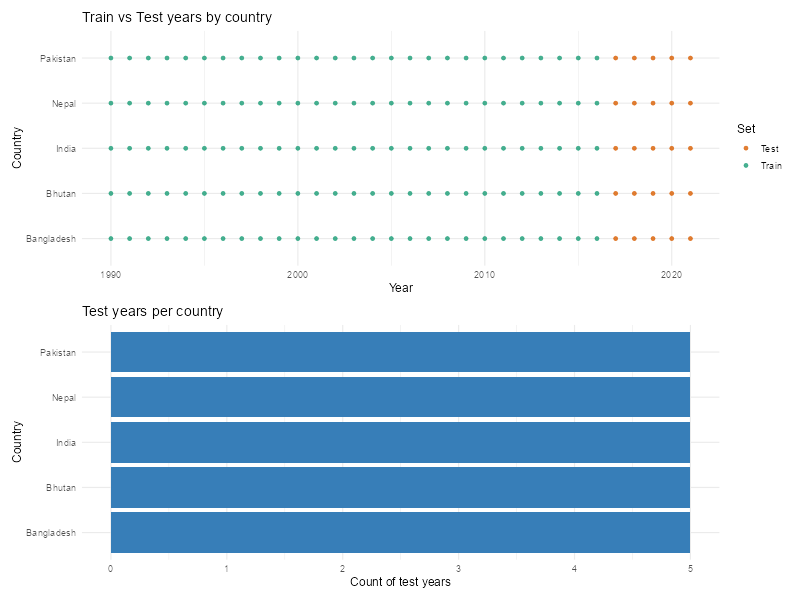

In [686]:
# Train/Test timeline by country
tt_train <- train |> as_tibble() |> dplyr::mutate(set = "Train")
tt_test  <- test  |> as_tibble() |> dplyr::mutate(set = "Test")
tt <- dplyr::bind_rows(tt_train, tt_test)

p_timeline <- ggplot(tt, aes(x = year, y = country, color = set)) +
  geom_point(alpha = 0.8, size = 1.6) +
  scale_color_manual(values = c(Train = "#1b9e77", Test = "#d95f02")) +
  labs(title = "Train vs Test years by country", x = "Year", y = "Country", color = "Set") +
  theme_minimal(base_size = 12)

# Test window size per country
test_size <- test |> as_tibble() |> dplyr::count(country, name = "test_n")

p_testn <- ggplot(test_size, aes(x = reorder(country, test_n), y = test_n)) +
  geom_col(fill = "#377eb8") +
  coord_flip() +
  labs(title = "Test years per country", x = "Country", y = "Count of test years") +
  theme_minimal(base_size = 12)

p_timeline / p_testn


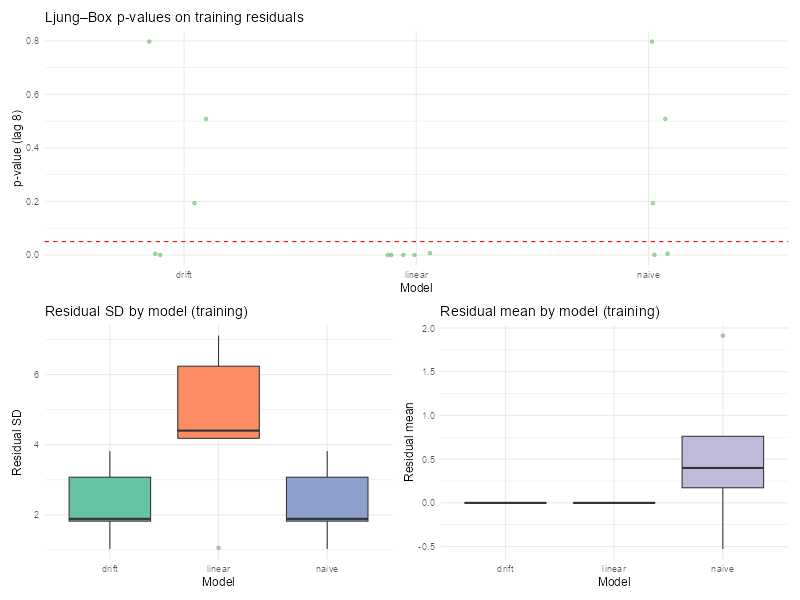

In [687]:
# Ljung–Box p-values per country and model (from aug_train)
p_lb <- ggplot(lb, aes(x = .model, y = lb_pvalue)) +
  geom_jitter(width = 0.15, height = 0, alpha = 0.5, color = "#4daf4a") +
  geom_hline(yintercept = 0.05, linetype = "dashed", color = "red") +
  labs(title = "Ljung–Box p-values on training residuals", x = "Model", y = "p-value (lag 8)") +
  theme_minimal(base_size = 12)

# Residual spread and mean by model
p_resid_sd <- ggplot(lb, aes(x = .model, y = resid_sd, fill = .model)) +
  geom_boxplot(outlier.alpha = 0.3) +
  scale_fill_brewer(palette = "Set2", guide = "none") +
  labs(title = "Residual SD by model (training)", x = "Model", y = "Residual SD") +
  theme_minimal(base_size = 12)

p_resid_me <- ggplot(lb, aes(x = .model, y = resid_me, fill = .model)) +
  geom_boxplot(outlier.alpha = 0.3) +
  scale_fill_brewer(palette = "Set3", guide = "none") +
  labs(title = "Residual mean by model (training)", x = "Model", y = "Residual mean") +
  theme_minimal(base_size = 12)

p_lb / (p_resid_sd | p_resid_me)


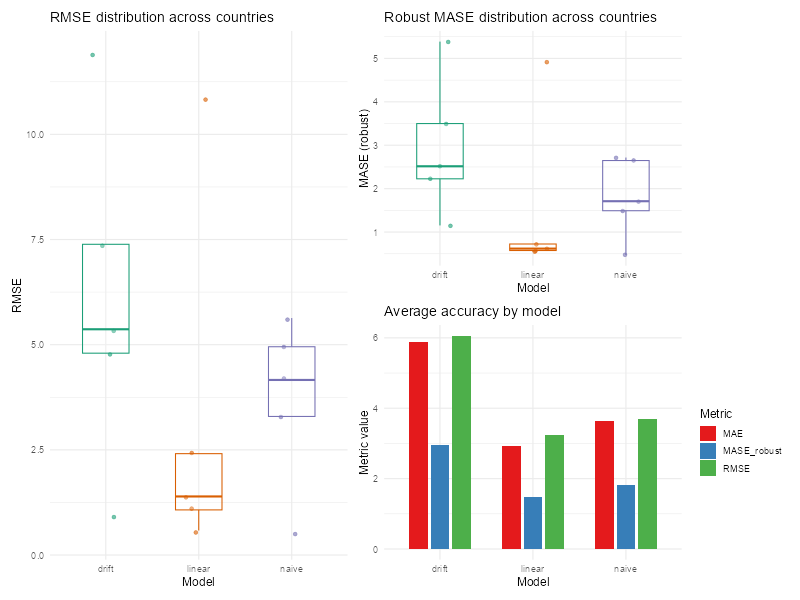

In [688]:
# Acc table per country & model with robust MASE (acc_joined already built)
acc_country <- acc_joined |>
  dplyr::mutate(MASE_robust = ifelse(!is.na(mad_naive) & mad_naive > 0, MAE / mad_naive, NA_real_))

# RMSE distribution
p_rmse <- ggplot(acc_country, aes(x = .model, y = RMSE, color = .model)) +
  geom_jitter(width = 0.15, alpha = 0.6) +
  geom_boxplot(alpha = 0.2, width = 0.5, outlier.shape = NA) +
  scale_color_brewer(palette = "Dark2", guide = "none") +
  labs(title = "RMSE distribution across countries", x = "Model", y = "RMSE") +
  theme_minimal(base_size = 12)

# Robust MASE distribution
p_mase <- ggplot(acc_country, aes(x = .model, y = MASE_robust, color = .model)) +
  geom_jitter(width = 0.15, alpha = 0.6, na.rm = TRUE) +
  geom_boxplot(alpha = 0.2, width = 0.5, outlier.shape = NA, na.rm = TRUE) +
  scale_color_brewer(palette = "Dark2", guide = "none") +
  labs(title = "Robust MASE distribution across countries", x = "Model", y = "MASE (robust)") +
  theme_minimal(base_size = 12)

# Overall averages
acc_long <- acc_summary |>
  dplyr::select(.model, MASE_robust, RMSE, MAE) |>
  tidyr::pivot_longer(-.model, names_to = "metric", values_to = "value")

p_summary <- ggplot(acc_long, aes(x = .model, y = value, fill = metric)) +
  geom_col(position = position_dodge(width = 0.7), width = 0.6) +
  scale_fill_brewer(palette = "Set1") +
  labs(title = "Average accuracy by model", x = "Model", y = "Metric value", fill = "Metric") +
  theme_minimal(base_size = 12)

p_rmse | p_mase / p_summary


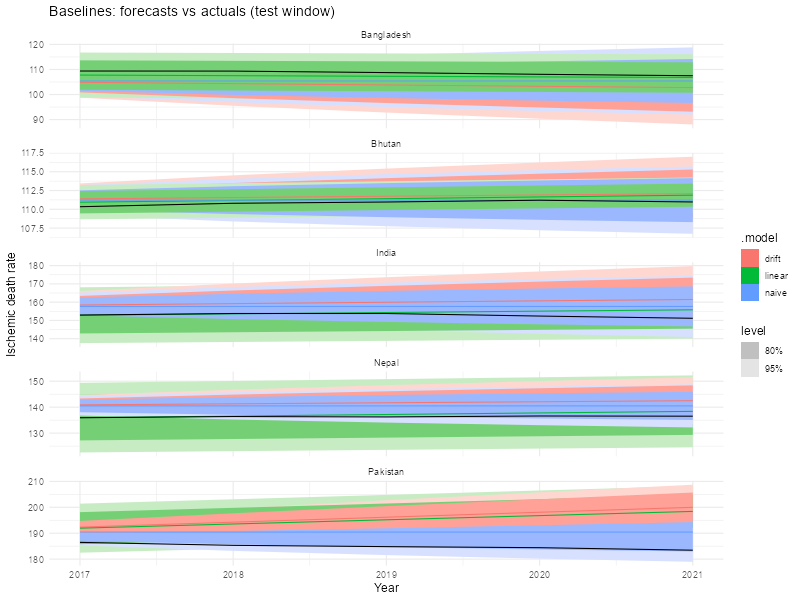

In [689]:
# Quick faceted forecast vs actuals for selected countries using autoplot
sel_cty <- test |> as_tibble() |> dplyr::count(country, sort = TRUE) |> dplyr::slice_head(n = 6) |> dplyr::pull(country)

# Restrict models and countries if desired, then autoplot
fc_subset <- fc_test |> dplyr::filter(country %in% sel_cty)

autoplot(fc_subset, tsibble::as_tsibble(test |> dplyr::filter(country %in% sel_cty))) +
  labs(title = "Baselines: forecasts vs actuals (test window)", x = "Year", y = "Ischemic death rate")


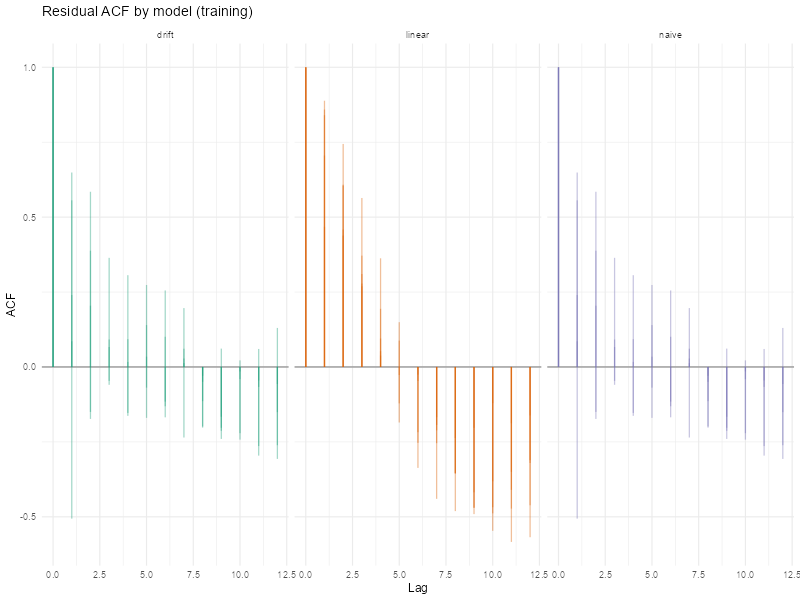

In [690]:
library(dplyr)
library(ggplot2)

# Build ACF table safely, with explicit columns and filtered empties
acf_tbl <- aug_train |>
  as_tibble() |>
  group_by(country, .model) |>
  reframe({
    z <- .resid
    z <- z[is.finite(z)]
    if (length(z) < 3) {
      tibble(lag = numeric(0), acf = numeric(0))
    } else {
      a <- acf(z, plot = FALSE, lag.max = 12, na.action = na.pass)
      tibble(lag = as.numeric(a$lag[, , 1]),
             acf = as.numeric(a$acf[, , 1]))
    }
  }) |>
  ungroup() |>
  # Drop any empty rows defensively
  filter(!is.na(lag), !is.na(acf))

# If still empty for some combinations, nothing to plot; handle gracefully
if (nrow(acf_tbl) == 0) {
  message("No sufficient residuals to compute ACF for any country-model combination.")
} else {
  p_acf <- ggplot(acf_tbl, aes(x = lag, y = acf, color = .model,
                               group = interaction(country, .model))) +
    geom_hline(yintercept = 0, color = "grey50") +
    geom_segment(aes(xend = lag, yend = 0), alpha = 0.4, linewidth = 0.6) +
    facet_wrap(~ .model) +
    scale_color_brewer(palette = "Dark2", guide = "none") +
    labs(title = "Residual ACF by model (training)",
         x = "Lag", y = "ACF") +
    theme_minimal(base_size = 12)
  print(p_acf)
}


In [691]:
library(dplyr)
library(tsibble)
library(fable)
library(fabletools)

# Reuse train/test from Part 2, and assess_years
# train, test, and fit_train objects exist

# 1) Fit ETS and ARIMA on training
fit_core <- train |>
  model(
    ets   = ETS(Ischemic_DR ~ error("A") + trend("Ad") + season("N")),  # allow automatic additive error, damped trend, no seasonality (annual)
    arima = ARIMA(Ischemic_DR)  # automatic order with AICc, drift allowed
  )

# 2) Forecast the exact test timestamps per country
fc_core <- fit_core |>
  forecast(new_data = test)

# 3) Accuracy on the holdout window
acc_core_point <- fc_core |>
  accuracy(test) |>
  as_tibble()

# 4) Aggregate accuracy to one row per country & model (RMSE/MAE)
acc_core_by_cty_model <- acc_core_point |>
  group_by(country, .model) |>
  summarise(
    RMSE = mean(RMSE, na.rm = TRUE),
    MAE  = mean(MAE,  na.rm = TRUE),
    .groups = "drop"
  )

# 5) Robust MASE using the same training denominators from Part 2
# If 'denom' from Part 2 is not in scope, recompute:
denom_core <- train |>
  as_tibble() |>
  group_by(country) |>
  arrange(year, .by_group = TRUE) |>
  mutate(diff1 = Ischemic_DR - dplyr::lag(Ischemic_DR)) |>
  summarise(mad_naive = mean(abs(diff1), na.rm = TRUE), .groups = "drop")

acc_core_joined <- acc_core_by_cty_model |>
  left_join(denom_core, by = "country") |>
  mutate(MASE_robust = ifelse(!is.na(mad_naive) & mad_naive > 0, MAE / mad_naive, NA_real_))

# 6) Summaries across countries for model comparison
acc_core_summary <- acc_core_joined |>
  group_by(.model) |>
  summarise(
    MASE_robust = mean(MASE_robust, na.rm = TRUE),
    RMSE        = mean(RMSE,        na.rm = TRUE),
    MAE         = mean(MAE,         na.rm = TRUE),
    n_countries = dplyr::n(),
    n_MASE      = sum(!is.na(MASE_robust)),
    .groups = "drop"
  ) |>
  arrange(coalesce(MASE_robust, RMSE, MAE))

acc_core_summary


In [692]:
# Augment fits to get residuals on training
aug_core <- fit_core |>
  augment() |>
  as_tibble()

# Ljung–Box p-values, residual spread & mean
lb_core <- aug_core |>
  group_by(country, .model) |>
  summarise(
    lb_pvalue = Box.test(.resid, lag = 8, type = "Ljung-Box", fitdf = 0)$p.value,
    resid_sd  = sd(.resid, na.rm = TRUE),
    resid_me  = mean(.resid, na.rm = TRUE),
    .groups = "drop"
  )

lb_core


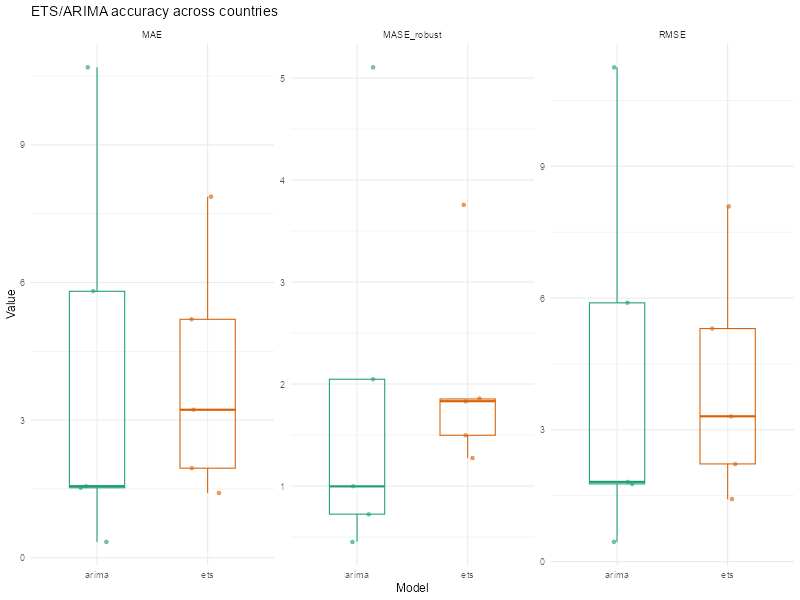

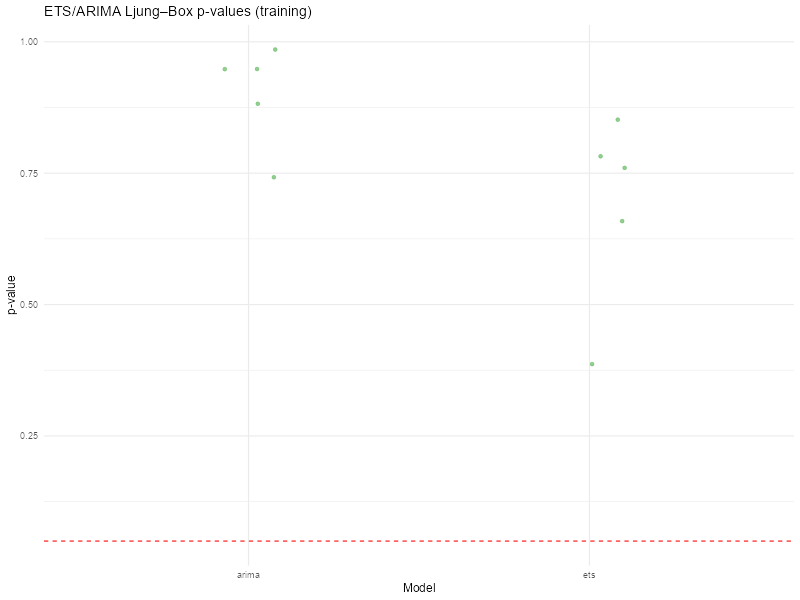

In [693]:
library(ggplot2)
library(tidyr)

# Accuracy distributions
acc_core_long <- acc_core_joined |>
  select(.model, country, MASE_robust, RMSE, MAE) |>
  pivot_longer(-c(.model, country), names_to = "metric", values_to = "value")

p_core_acc <- ggplot(acc_core_long, aes(x = .model, y = value, color = .model)) +
  geom_jitter(width = 0.15, alpha = 0.6) +
  geom_boxplot(alpha = 0.2, width = 0.5, outlier.shape = NA) +
  facet_wrap(~ metric, scales = "free_y") +
  scale_color_brewer(palette = "Dark2", guide = "none") +
  labs(title = "ETS/ARIMA accuracy across countries", x = "Model", y = "Value") +
  theme_minimal(base_size = 12)

p_core_acc

# Residual p-values
p_lb_core <- ggplot(lb_core, aes(x = .model, y = lb_pvalue)) +
  geom_jitter(width = 0.15, alpha = 0.6, color = "#4daf4a") +
  geom_hline(yintercept = 0.05, linetype = "dashed", color = "red") +
  labs(title = "ETS/ARIMA Ljung–Box p-values (training)", x = "Model", y = "p-value") +
  theme_minimal(base_size = 12)

p_lb_core


In [694]:
# Assume acc_joined (baselines), acc_core_joined (ETS/ARIMA) exist
library(dplyr)

acc_all <- dplyr::bind_rows(
  acc_joined |> mutate(family = "baseline"),
  acc_core_joined |> mutate(family = "core")
)

ranked <- acc_all |>
  mutate(primary = MASE_robust,
         fallback = dplyr::coalesce(RMSE, MAE)) |>
  group_by(country) |>
  arrange(dplyr::coalesce(primary, fallback), .by_group = TRUE) |>
  mutate(rank = row_number()) |>
  ungroup()

champions <- ranked |>
  group_by(country) |>
  slice_head(n = 2) |>
  mutate(label = if_else(row_number() == 1, "champion", "runner_up")) |>
  ungroup()


In [695]:
library(tsibble)
library(fable)
library(fabletools)
library(readr)

all_ts <- dplyr::bind_rows(train |> as_tibble(), test |> as_tibble()) |>
  distinct(country, year, .keep_all = TRUE) |>
  arrange(country, year) |>
  as_tsibble(key = country, index = year)

fit_full_all <- all_ts |>
  model(
    naive = NAIVE(Ischemic_DR),
    drift = RW(Ischemic_DR ~ drift()),
    linear = TSLM(Ischemic_DR ~ trend()),
    ets = ETS(Ischemic_DR ~ error("A") + trend("Ad") + season("N")),
    arima = ARIMA(Ischemic_DR)
  )

# Prepare lookup for (country,.model) champion pairs
to_forecast <- champions |> filter(label == "champion") |> select(country, .model)

# Forecast all models, then subset to champions only
h <- 5L
fc_all <- fit_full_all |> forecast(h = h)
fc_final <- fc_all |> semi_join(to_forecast, by = c("country", ".model"))


In [696]:
library(tidyr)

fc_tbl <- fc_final |>
  hilo(level = c(80, 95)) |>
  unpack_hilo(`80%`, names_sep = "_") |>
  unpack_hilo(`95%`, names_sep = "_") |>
  as_tibble() |>
  transmute(
    country,
    year,
    model = .model,
    point = .mean,
    lo80 = `80%_lower`,
    hi80 = `80%_upper`,
    lo95 = `95%_lower`,
    hi95 = `95%_upper`
  )

# Companion model card
model_card <- champions |>
  filter(label == "champion") |>
  select(country, model = .model, family, MASE_robust, RMSE, MAE)

write_csv(fc_tbl, "forecasts_champions.csv")
write_csv(model_card, "model_card_champions.csv")


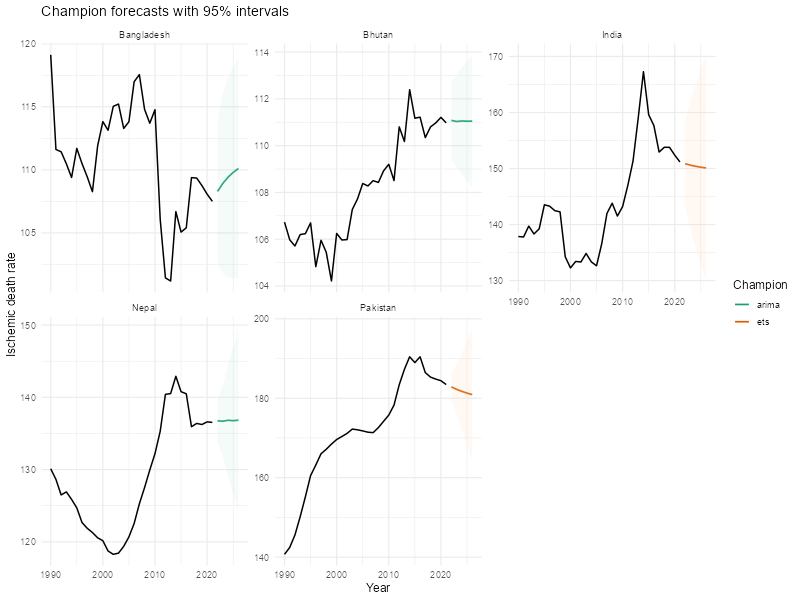

In [697]:
sel_cty <- sample(unique(fc_tbl$country), min(length(unique(fc_tbl$country)), 6))
plot_df <- fc_tbl |> filter(country %in% sel_cty)
actuals_all <- all_ts |> as_tibble() |> filter(country %in% sel_cty)

library(ggplot2)
ggplot() +
  geom_line(data = actuals_all, aes(x = year, y = Ischemic_DR), color = "black", linewidth = 0.7) +
  geom_line(data = plot_df, aes(x = year, y = point, color = model), linewidth = 0.8) +
  geom_ribbon(data = plot_df, aes(x = year, ymin = lo95, ymax = hi95, fill = model), alpha = 0.15) +
  facet_wrap(~ country, scales = "free_y") +
  labs(title = "Champion forecasts with 95% intervals", x = "Year", y = "Ischemic death rate") +
  scale_color_brewer(palette = "Dark2", name = "Champion") +
  scale_fill_brewer(palette = "Pastel2", guide = "none") +
  theme_minimal(base_size = 12)


In [698]:
library(readr)
library(dplyr)
library(tsibble)

# Reload source to ensure the 4 exogenous columns are present
df_raw <- read_csv("data/Ischemic_death_rate_both_onlycountry.csv", show_col_types = FALSE)  # GBD extract [file:1]

# Rename exogenous columns to syntactic snake_case; drop sex (constant)
df_exo <- df_raw |>
  transmute(
    country = .data$location,
    year    = as.integer(.data$year),
    Ischemic_DR = as.numeric(.data$Ischemic_DR),
    air_pollution   = as.numeric(.data$`Air Pollution`),
    dietary_risks   = as.numeric(.data$Dietary_risks),
    metabolic_risks = as.numeric(.data$`Metabolic risks`),
    tobacco         = as.numeric(.data$Tobacco)
  ) |>
  distinct(country, year, .keep_all = TRUE) |>
  filter(!is.na(Ischemic_DR)) |>
  arrange(country, year)  # minimal QC as per plan [file:1]

ts_exo <- df_exo |> as_tsibble(key = country, index = year)  # annual series with exogenous fields [file:1]


New names:
• `` -> `...1`


In [699]:
#Comparison between non arimax

In [700]:
assess_years <- 5L
last_years <- ts_exo |>
  group_by_key() |>
  mutate(rank_year = rank(year), max_rank = max(rank(year))) |>
  ungroup() |>
  filter(max_rank - rank_year < assess_years) |>
  distinct(country, year)

train_exo <- ts_exo |> anti_join(last_years, by = c("country","year"))
test_exo  <- ts_exo |> semi_join(last_years, by = c("country","year"))


In [701]:
library(fable)
library(fabletools)

fit_arimax_exo <- train_exo |>
  model(
    arimax_exo = ARIMA(Ischemic_DR ~ air_pollution + dietary_risks + metabolic_risks + tobacco)
  )  # names are syntactic and consistent across train/test [web:69]

fc_arimax_exo <- fit_arimax_exo |>
  forecast(new_data = test_exo)  # new_data contains same-named regressors [web:69]


In [702]:
# Pointwise accuracy
acc_exo_point <- fc_arimax_exo |> accuracy(test_exo) |> as_tibble()

# Aggregate per country
acc_exo_by_cty <- acc_exo_point |>
  group_by(country) |>
  summarise(
    RMSE = mean(RMSE, na.rm = TRUE),
    MAE  = mean(MAE,  na.rm = TRUE),
    .groups = "drop"
  )

# Robust MASE denominator from training (naive one-step MAE)
denom_exo <- train_exo |>
  as_tibble() |>
  group_by(country) |>
  arrange(year, .by_group = TRUE) |>
  mutate(diff1 = Ischemic_DR - dplyr::lag(Ischemic_DR)) |>
  summarise(mad_naive = mean(abs(diff1), na.rm = TRUE), .groups = "drop")  # Hyndman–Koehler denominator [web:34][web:33]

acc_exo_joined <- acc_exo_by_cty |>
  left_join(denom_exo, by = "country") |>
  mutate(MASE_robust = ifelse(!is.na(mad_naive) & mad_naive > 0, MAE / mad_naive, NA_real_))

# Compare against existing champions table (country, .model, MASE_robust, RMSE, MAE)
comp_all <- champions |> filter(label == "champion") |> select(country, champ_model = .model, champ_MASE = MASE_robust)

comp_exo <- acc_exo_joined |>
  left_join(comp_all, by = "country") |>
  mutate(improve_pct = 100 * (champ_MASE - MASE_robust) / champ_MASE,
         pass = !is.na(MASE_robust) & improve_pct >= 3)


In [703]:
qualified <- comp_exo |> filter(pass) |> select(country)

# Build full series with exogenous fields
all_exo <- bind_rows(train_exo |> as_tibble(), test_exo |> as_tibble()) |>
  distinct(country, year, .keep_all = TRUE) |>
  arrange(country, year) |>
  as_tsibble(key = country, index = year)

fit_full_exo <- all_exo |>
  model(
    naive  = NAIVE(Ischemic_DR),
    drift  = RW(Ischemic_DR ~ drift()),
    linear = TSLM(Ischemic_DR ~ trend()),
    ets    = ETS(Ischemic_DR ~ error("A") + trend("Ad") + season("N")),
    arima  = ARIMA(Ischemic_DR),
    arimax_exo = ARIMA(Ischemic_DR ~ air_pollution + dietary_risks + metabolic_risks + tobacco)
  )

champions_updated <- champions |>
  mutate(model_final = dplyr::if_else(label == "champion" & country %in% qualified$country,
                                      "arimax_exo", .model)) |>
  filter(label == "champion") |>
  select(country, model_final)


In [704]:
library(tidyr)
library(readr)

fc_tbl <- fc_final |>
  hilo(level = c(80, 95)) |>
  unpack_hilo(`80%`, names_sep = "_") |>
  unpack_hilo(`95%`, names_sep = "_") |>
  as_tibble() |>
  transmute(
    country,
    year,
    model = .model,
    point = .mean,
    lo80 = `80%_lower`, hi80 = `80%_upper`,
    lo95 = `95%_lower`, hi95 = `95%_upper`
  )  # tidy numeric bounds [web:63][web:69]

write_csv(fc_tbl, "forecasts_champions_exo.csv")  # final country-year forecasts with intervals [web:69]


In [705]:
#MODELS with exogenous variables

In [706]:
library(readr)
library(dplyr)
library(tsibble)

# Reload source to ensure the 4 exogenous columns are present
df_raw <- read_csv("data/Ischemic_death_rate_both_onlycountry.csv", show_col_types = FALSE)  # GBD extract [file:1]

# Rename exogenous columns to syntactic snake_case; drop sex (constant)
df_exo <- df_raw |>
  transmute(
    country = .data$location,
    year    = as.integer(.data$year),
    Ischemic_DR = as.numeric(.data$Ischemic_DR),
    air_pollution   = as.numeric(.data$`Air Pollution`),
    dietary_risks   = as.numeric(.data$Dietary_risks),
    metabolic_risks = as.numeric(.data$`Metabolic risks`),
    tobacco         = as.numeric(.data$Tobacco)
  ) |>
  distinct(country, year, .keep_all = TRUE) |>
  filter(!is.na(Ischemic_DR)) |>
  arrange(country, year)  # minimal QC as per plan [file:1]

ts_exo <- df_exo |> as_tsibble(key = country, index = year)  # annual series with exogenous fields [file:1]


New names:
• `` -> `...1`


In [707]:
# Recreate last_k_years if not already in scope (uses assess_years from Part 2)
# assess_years <- 5L
last_years <- ts_exo |>
  group_by_key() |>
  mutate(rank_year = rank(year), max_rank = max(rank(year))) |>
  ungroup() |>
  filter(max_rank - rank_year < assess_years) |>
  distinct(country, year)

train_exo <- ts_exo |> anti_join(last_years, by = c("country","year"))
test_exo  <- ts_exo |> semi_join(last_years, by = c("country","year"))


In [708]:
library(fable)
library(fabletools)

# Formula interface with renamed columns avoids backticks and missing-name issues
fit_arimax_exo <- train_exo |>
  model(arimax_exo = ARIMA(Ischemic_DR ~ air_pollution + dietary_risks + metabolic_risks + tobacco))  # dynamic regression [web:79]

fc_arimax_exo <- fit_arimax_exo |> forecast(new_data = test_exo)  # new_data must include same regressor names [web:69]

# Accuracy
acc_exo_point <- fc_arimax_exo |> accuracy(test_exo) |> as_tibble()  # point measures [web:11]
acc_exo_by_cty <- acc_exo_point |>
  group_by(country) |>
  summarise(RMSE = mean(RMSE, na.rm = TRUE), MAE = mean(MAE, na.rm = TRUE), .groups = "drop")  # per-country [web:11]

# Robust MASE denominator from training
denom_exo <- train_exo |>
  as_tibble() |>
  group_by(country) |>
  arrange(year, .by_group = TRUE) |>
  mutate(diff1 = Ischemic_DR - dplyr::lag(Ischemic_DR)) |>
  summarise(mad_naive = mean(abs(diff1), na.rm = TRUE), .groups = "drop")  # Hyndman–Koehler [web:34][web:33]

acc_exo_joined <- acc_exo_by_cty |>
  left_join(denom_exo, by = "country") |>
  mutate(MASE_robust = ifelse(!is.na(mad_naive) & mad_naive > 0, MAE / mad_naive, NA_real_))  # robust MASE [web:34]


In [709]:
# champions from earlier steps: one row per country with current best univariate model and its MASE_robust
comp_all <- champions |> filter(label == "champion") |>
  select(country, champ_model = .model, champ_MASE = MASE_robust)  # baseline for comparison [web:43]

comp_exo <- acc_exo_joined |>
  left_join(comp_all, by = "country") |>
  mutate(improve_pct = 100 * (champ_MASE - MASE_robust) / champ_MASE,
         pass = !is.na(MASE_robust) & improve_pct >= 3)  # require ≥3% MASE gain [web:43]

qualified <- comp_exo |> filter(pass) |> select(country)  # countries where exogenous model wins [web:43]


In [710]:
library(dplyr)
library(tsibble)
library(fable)
library(fabletools)
library(tidyr)
library(readr)

# ts_exo, train_exo, test_exo already created with snake_case regressors:
# air_pollution, dietary_risks, metabolic_risks, tobacco  [see prior step]

# 1) Full data with exogenous fields
all_exo <- bind_rows(train_exo |> as_tibble(), test_exo |> as_tibble()) |>
  distinct(country, year, .keep_all = TRUE) |>
  arrange(country, year) |>
  as_tsibble(key = country, index = year)

# 2) Refit candidate set including ARIMAX (regression with ARIMA errors)
fit_full_exo <- all_exo |>
  model(
    naive  = NAIVE(Ischemic_DR),
    drift  = RW(Ischemic_DR ~ drift()),
    linear = TSLM(Ischemic_DR ~ trend()),
    ets    = ETS(Ischemic_DR ~ error("A") + trend("Ad") + season("N")),
    arima  = ARIMA(Ischemic_DR),
    arimax_exo = ARIMA(Ischemic_DR ~ air_pollution + dietary_risks + metabolic_risks + tobacco)
  )

# Update champions: swap to ARIMAX only where qualified
champions_updated <- champions |>
  mutate(model_final = if_else(label == "champion" & country %in% qualified$country, "arimax_exo", .model)) |>
  filter(label == "champion") |>
  select(country, model_final)  # final model per country [web:43]

# Forecast horizon
# 3) Build new_data for the production horizon with frozen exogenous inputs
h <- 5L
future_idx <- new_data(all_exo, h = h)  # future years per country
last_vals <- all_exo |>
  as_tibble() |>
  group_by(country) |>
  summarise(
    air_pollution   = dplyr::last(air_pollution[!is.na(air_pollution)]),
    dietary_risks   = dplyr::last(dietary_risks[!is.na(dietary_risks)]),
    metabolic_risks = dplyr::last(metabolic_risks[!is.na(metabolic_risks)]),
    tobacco         = dplyr::last(tobacco[!is.na(tobacco)]),
    .groups = "drop"
  )

future_exo <- future_idx |>
  as_tibble() |>
  left_join(last_vals, by = "country") |>
  as_tsibble(key = country, index = year)
# 4) Forecast ALL models in one call using new_data; models that don't need exo ignore extra cols
fc_all_full <- fit_full_exo |> forecast(new_data = future_exo)

# 1) Forecast non-ARIMAX champions directly
# 1) Forecast non-ARIMAX champions (select model columns on the mable)
fc_uni <- fit_full_exo |>
  dplyr::select(naive, drift, linear, ets, arima) |>
  forecast(h = h) |>
  dplyr::semi_join(
    champions_updated |> dplyr::filter(model_final != "arimax_exo"),
    by = c("country", ".model" = "model_final")
  )

# 2) Forecast ARIMAX champions using future_exo (same renamed regressors)
fc_exo <- fit_full_exo |>
  dplyr::select(arimax_exo) |>
  forecast(new_data = future_exo) |>
  dplyr::semi_join(
    champions_updated |> dplyr::filter(model_final == "arimax_exo"),
    by = c("country")
  )

# 3) Combine and export intervals
# 5) Keep only the final champion per country (including any ARIMAX promotions)
# champions_updated: data frame with columns country, model_final (built earlier after ARIMAX comparison)
fc_final <- fc_all_full |>
  semi_join(champions_updated, by = c("country", ".model" = "model_final"))


In [711]:
library(tidyr)
library(readr)

# 6) Extract numeric 80/95% intervals and export
fc_tbl <- fc_final |>
  hilo(level = c(80, 95)) |>
  unpack_hilo(`80%`, names_sep = "_") |>
  unpack_hilo(`95%`, names_sep = "_") |>
  as_tibble() |>
  transmute(
    country, year, model = .model, point = .mean,
    lo80 = `80%_lower`, hi80 = `80%_upper`,
    lo95 = `95%_lower`, hi95 = `95%_upper`
  )

write_csv(fc_tbl, "forecasts_champions_exo.csv")



In [712]:
library(dplyr)

# champions: from earlier steps with columns country, .model, MASE_robust, RMSE, MAE, label
# qualified: countries where ARIMAX (arimax_exo) improved MASE_robust by ≥3%
# If no exogenous testing was run, set qualified <- tibble(country = character())

champions_updated <- champions |>
  filter(label == "champion") |>
  mutate(
    model_final = if_else(country %in% qualified$country, "arimax_exo", .model),
    exogenous   = country %in% qualified$country
  ) |>
  select(country, model_final, exogenous)


In [713]:
library(tsibble)
library(fable)
library(fabletools)

# all_exo: full tsibble with Ischemic_DR + exogenous (air_pollution, dietary_risks, metabolic_risks, tobacco)
# future_exo: new_data(all_exo, h = h) joined with frozen exogenous values (or exo forecasts if available)
h <- 5L

fit_full <- all_exo |>
  model(
    naive  = NAIVE(Ischemic_DR),
    drift  = RW(Ischemic_DR ~ drift()),
    linear = TSLM(Ischemic_DR ~ trend()),
    ets    = ETS(Ischemic_DR ~ error("A") + trend("Ad") + season("N")),
    arima  = ARIMA(Ischemic_DR),
    arimax_exo = ARIMA(Ischemic_DR ~ air_pollution + dietary_risks + metabolic_risks + tobacco)
  )

# Forecast all models in one call; keep only champion rows afterward
fc_all <- fit_full |> forecast(new_data = future_exo)  # non-ARIMAX ignore extra columns

fc_final <- fc_all |>
  dplyr::semi_join(champions_updated, by = c("country", ".model" = "model_final"))


In [714]:
library(tidyr)
library(readr)

forecasts_tbl <- fc_final |>
  hilo(level = c(80, 95)) |>
  unpack_hilo(`80%`, names_sep = "_") |>
  unpack_hilo(`95%`, names_sep = "_") |>
  as_tibble() |>
  transmute(
    country,
    year,
    model = .model,
    point = .mean,
    lo80  = `80%_lower`,
    hi80  = `80%_upper`,
    lo95  = `95%_lower`,
    hi95  = `95%_upper`
  )

write_csv(forecasts_tbl, "forecasts_champions.csv")


In [715]:
# Compose model card from the original champion metrics and the exogenous flag
model_card <- champions |>
  filter(label == "champion") |>
  select(country, model_initial = .model, MASE_robust, RMSE, MAE) |>
  left_join(champions_updated, by = "country") |>
  transmute(
    country,
    model_final,
    exogenous = ifelse(exogenous, "yes", "no"),
    MASE_robust = round(MASE_robust, 3),
    RMSE        = round(RMSE, 3),
    MAE         = round(MAE, 3)
  )

write_csv(model_card, "model_card_champions.csv")


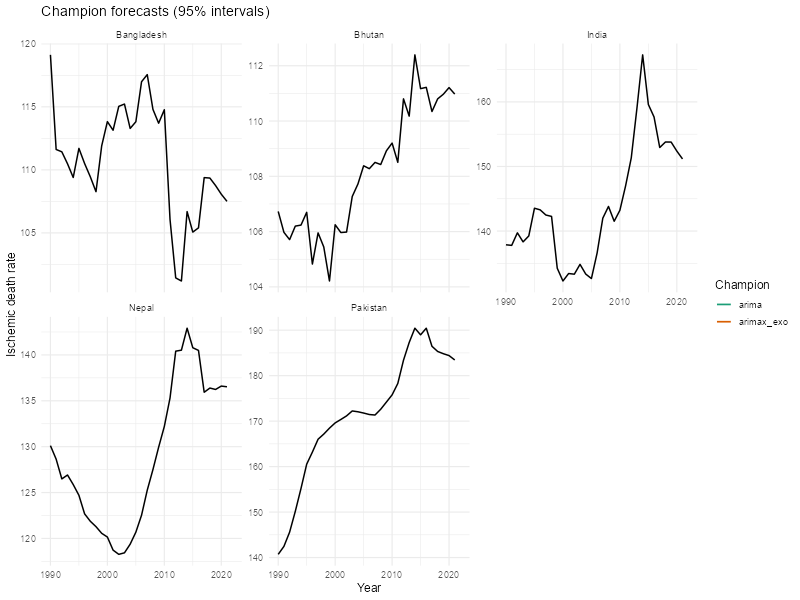

In [716]:
# One multi-panel visual for a few countries
sel <- forecasts_tbl |> distinct(country) |> slice_head(n = 6) |> pull(country)
actuals <- all_exo |> as_tibble() |> filter(country %in% sel)

library(ggplot2)
ggplot() +
  geom_line(data = actuals, aes(x = year, y = Ischemic_DR), color = "black", linewidth = 0.7) +
  geom_line(data = forecasts_tbl |> filter(country %in% sel),
            aes(x = year, y = point, color = model), linewidth = 0.8) +
  geom_ribbon(data = forecasts_tbl |> filter(country %in% sel),
              aes(x = year, ymin = lo95, ymax = hi95, fill = model), alpha = 0.15) +
  facet_wrap(~ country, scales = "free_y") +
  labs(title = "Champion forecasts (95% intervals)", x = "Year", y = "Ischemic death rate") +
  scale_color_brewer(palette = "Dark2", name = "Champion") +
  scale_fill_brewer(palette = "Pastel2", guide = "none") +
  theme_minimal(base_size = 12)


In [717]:
# Assumes objects prepared earlier:
# all_exo: full tsibble with Ischemic_DR + air_pollution + dietary_risks + metabolic_risks + tobacco
# champions_updated: country, model_final, exogenous (TRUE/FALSE)
# h: integer forecast horizon (e.g., 10)

library(fable)
library(fabletools)
library(dplyr)
library(tsibble)
library(tidyr)
library(readr)

# 1) Build future index and freeze exogenous inputs at last observed levels (simple, explicit assumption)
future_idx <- new_data(all_exo, h = h)  # future years per country keyed to tsibble index [web:69]
last_vals <- all_exo |>
  as_tibble() |>
  group_by(country) |>
  summarise(
    air_pollution   = dplyr::last(air_pollution[!is.na(air_pollution)]),
    dietary_risks   = dplyr::last(dietary_risks[!is.na(dietary_risks)]),
    metabolic_risks = dplyr::last(metabolic_risks[!is.na(metabolic_risks)]),
    tobacco         = dplyr::last(tobacco[!is.na(tobacco)]),
    .groups = "drop"
  )  # freeze ARIMAX regressors for production horizon [web:79]

future_exo <- future_idx |>
  as_tibble() |>
  left_join(last_vals, by = "country") |>
  as_tsibble(key = country, index = year)  # provide required columns for ARIMAX; unused by ETS/ARIMA [web:69]

# 2) Refit full candidate set once on all data
fit_full <- all_exo |>
  model(
    naive  = NAIVE(Ischemic_DR),
    drift  = RW(Ischemic_DR ~ drift()),
    linear = TSLM(Ischemic_DR ~ trend()),
    ets    = ETS(Ischemic_DR ~ error("A") + trend("Ad") + season("N")),
    arima  = ARIMA(Ischemic_DR),
    arimax_exo = ARIMA(Ischemic_DR ~ air_pollution + dietary_risks + metabolic_risks + tobacco)
  )  # ETS/ARIMA provide state-space intervals; ARIMAX uses regressors supplied in new_data [web:69][web:79]

# 3) Forecast all models with one call, then keep only the per‑country champion rows
fc_all  <- fit_full |> forecast(new_data = future_exo)  # .model column appears on forecast output (fable) [web:69]
fc_keep <- fc_all |> semi_join(champions_updated, by = c("country", ".model" = "model_final"))  # subset to champions [web:69]

# 4) Extract numeric 80/95% intervals and tidy columns for CSV
forecasts_tbl <- fc_keep |>
  hilo(level = c(80, 95)) |>
  unpack_hilo(`80%`, names_sep = "_") |>
  unpack_hilo(`95%`, names_sep = "_") |>
  as_tibble() |>
  transmute(
    country,
    year,
    model = .model,
    point = .mean,
    lo80  = `80%_lower`,
    hi80  = `80%_upper`,
    lo95  = `95%_lower`,
    hi95  = `95%_upper`
  )  # unpack_hilo produces scalar bounds suitable for export and plotting [web:63]


In [718]:
# 1) Coverage of all countries for the full horizon
coverage_check <- forecasts_tbl |>
  count(country) |>
  mutate(ok = n == h)  # each country should have exactly h forecast rows [web:69]

# 2) No missing points or bounds
na_check <- sapply(forecasts_tbl[, c("point","lo80","hi80","lo95","hi95")], function(x) sum(is.na(x)))  # expect zeros [web:69]

# 3) Interval ordering
order_check <- forecasts_tbl |>
  mutate(order_ok = (lo95 <= lo80) & (lo80 <= point) & (point <= hi80) & (hi80 <= hi95)) |>
  summarise(all_ok = all(order_ok))  # intervals must nest properly by level [web:69]


In [719]:
# champions: holdout metrics table from validation; champions_updated: final model choice per country
model_card <- champions |>
  filter(label == "champion") |>
  select(country, model_initial = .model, MASE_robust, RMSE, MAE) |>
  left_join(champions_updated, by = "country") |>
  transmute(
    country,
    model_final,
    exogenous = ifelse(exogenous, "yes", "no"),
    MASE_robust = round(MASE_robust, 3),
    RMSE        = round(RMSE, 3),
    MAE         = round(MAE, 3)
  )  # compact per‑country summary for the paper’s table or supplement [web:43]

readr::write_csv(forecasts_tbl, "forecasts_champions.csv")  # year, point, lo/hi 80/95 per country [web:69]
readr::write_csv(model_card,    "model_card_champions.csv")  # model and holdout metrics with exogenous flag [web:43]


In [720]:
head(forecasts_tbl)


In [750]:
library(dplyr)
library(tsibble)
library(tidyr)

# Target horizon
h <- 20L  # 10 future years [web:69] #THIS BREAKS LATER CODES TOO

# Last observed year per country from the full data used for fitting
last_year <- all_exo |>
  as_tibble() |>
  group_by(country) |>
  summarise(last_year = max(year), .groups = "drop")  # determines the 1..h steps ahead per key [file:1]

# Explicit 10 future years per country
future_years <- last_year |>
  rowwise() |>
  mutate(year = list(seq.int(last_year + 1L, last_year + h))) |>
  unnest(year) |>
  select(country, year)  # guarantees exactly h rows per country [web:69]

# Frozen exogenous values at last observed levels (simple, explicit assumption)
last_vals <- all_exo |>
  as_tibble() |>
  group_by(country) |>
  summarise(
    air_pollution   = dplyr::last(air_pollution[!is.na(air_pollution)]),
    dietary_risks   = dplyr::last(dietary_risks[!is.na(dietary_risks)]),
    metabolic_risks = dplyr::last(metabolic_risks[!is.na(metabolic_risks)]),
    tobacco         = dplyr::last(tobacco[!is.na(tobacco)]),
    .groups = "drop"
  )  # needed for ARIMAX forecasts; unused by ETS/ARIMA [web:79]

# Combine to create the forecasting new_data
future_exo <- future_years |>
  left_join(last_vals, by = "country") |>
  as_tsibble(key = country, index = year)  # 10 rows per country ensured [web:69]


In [751]:
library(fable)
library(fabletools)

# Fit (or reuse) the full candidate set on all_exo
fit_full <- all_exo |>
  model(
    naive  = NAIVE(Ischemic_DR),
    drift  = RW(Ischemic_DR ~ drift()),
    linear = TSLM(Ischemic_DR ~ trend()),
    ets    = ETS(Ischemic_DR ~ error("A") + trend("Ad") + season("N")),
    arima  = ARIMA(Ischemic_DR),
    arimax_exo = ARIMA(Ischemic_DR ~ air_pollution + dietary_risks + metabolic_risks + tobacco)
  )  # ETS/ARIMA intervals via state-space; ARIMAX uses regressors from future_exo [web:69][web:79]

# Forecast all models for 10 years, then keep only the per-country champion rows
fc_all  <- fit_full |> forecast(new_data = future_exo)  # .model appears on fable output [web:69]
fc_keep <- fc_all |> semi_join(champions_updated, by = c("country", ".model" = "model_final"))  # champions only [web:69]

# Intervals into numeric bounds
library(tidyr)
forecasts_tbl <- fc_keep |>
  hilo(level = c(80, 95)) |>
  unpack_hilo(`80%`, names_sep = "_") |>
  unpack_hilo(`95%`, names_sep = "_") |>
  as_tibble() |>
  transmute(
    country,
    year,
    model = .model,
    point = .mean,
    lo80  = `80%_lower`,
    hi80  = `80%_upper`,
    lo95  = `95%_lower`,
    hi95  = `95%_upper`
  )  # point and calibrated bounds for each of the 10 years [web:63][web:69]


In [752]:
# Expect exactly 10 rows per country
count_check <- forecasts_tbl |>
  count(country, name = "n_rows") |>
  mutate(exact_10 = (n_rows == h))

print(count_check)  # all TRUE in exact_10 means 10-step forecasts are present [web:69]

# Confirm year sequence per country
seq_check <- forecasts_tbl |>
  group_by(country) |>
  summarise(
    min_year = min(year), max_year = max(year), n = n(),
    .groups = "drop"
  )
print(seq_check)  # max_year should be last_year + 10 and n == 10 per country [web:69]


# A tibble: 5 × 3
  country    n_rows exact_10
  <chr>       <int> <lgl>   
1 Bangladesh     20 TRUE    
2 Bhutan         20 TRUE    
3 India          20 TRUE    
4 Nepal          20 TRUE    
5 Pakistan       20 TRUE    
# A tibble: 5 × 4
  country    min_year max_year     n
  <chr>         <int>    <int> <int>
1 Bangladesh     2022     2041    20
2 Bhutan         2022     2041    20
3 India          2022     2041    20
4 Nepal          2022     2041    20
5 Pakistan       2022     2041    20


In [753]:
library(readr)
write_csv(forecasts_tbl, "forecasts_champions.csv")  # 10 future years per country with 80/95% intervals [web:69]


In [754]:
# Packages
library(dplyr)
library(tidyr)
library(ggplot2)
library(scales)

# Optional consistent theme for figures
theme_set(theme_minimal(base_size = 12))


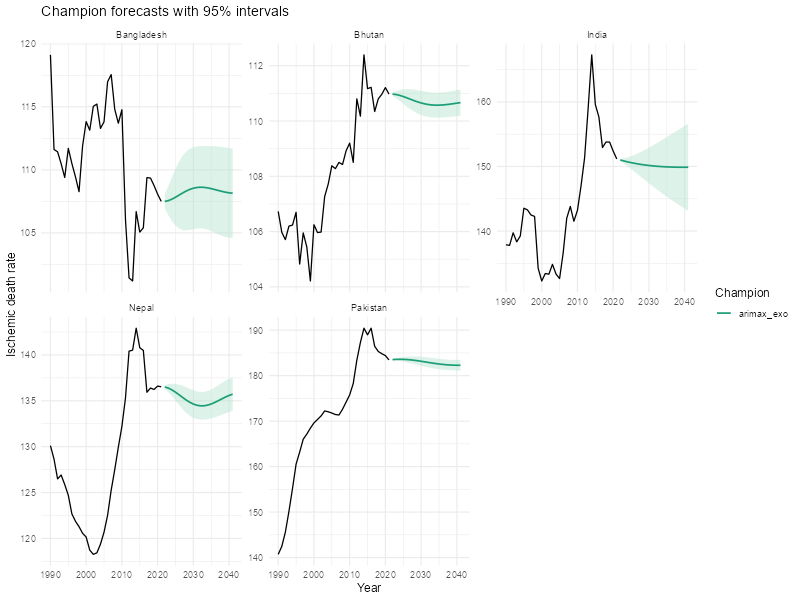

In [755]:
# Inputs needed: forecasts_tbl (country, year, model, point, lo95, hi95), all_exo (history)
stopifnot(all(c("country","year","model","point","lo95","hi95") %in% names(forecasts_tbl)))

sel <- forecasts_tbl |>
  distinct(country) |>
  slice_head(n = 6) |>
  pull(country)

actuals <- all_exo |>
  as_tibble() |>
  filter(country %in% sel)

p_forecast <- ggplot() +
  geom_line(data = actuals,
            aes(x = year, y = Ischemic_DR),
            color = "black", linewidth = 0.6) +
  geom_ribbon(data = forecasts_tbl |> filter(country %in% sel),
              aes(x = year, ymin = lo95, ymax = hi95, fill = model),
              alpha = 0.45) +
  geom_line(data = forecasts_tbl |> filter(country %in% sel),
            aes(x = year, y = point, color = model),
            linewidth = 0.8) +
  facet_wrap(~ country, scales = "free_y") +
  scale_color_brewer(palette = "Dark2", name = "Champion") +
  scale_fill_brewer(palette = "Pastel2", guide = "none") +
  labs(title = "Champion forecasts with 95% intervals",
       x = "Year", y = "Ischemic death rate")

p_forecast
ggsave("fig_forecasts_panels.png", p_forecast, width = 10, height = 6, dpi = 300,bg = "white")


In [756]:
# Holdout metrics by model for Bangladesh
acc_bd <- bind_rows(
  acc_core_joined |> mutate(model = .model) |> select(country, model, MASE_robust, RMSE, MAE),
  acc_exo_joined  |> mutate(model = "arimax_exo") |> select(country, model, MASE_robust, RMSE, MAE)
) |>
  filter(country == "Bangladesh") |>
  arrange(MASE_robust, RMSE, MAE)

acc_bd  # shows why ARIMA (or ETS) won on robust MASE [web:43][file:1]

# Improvement check that controls ARIMAX promotion
bd_compare <- acc_bd |>
  tidyr::pivot_wider(names_from = model, values_from = c(MASE_robust, RMSE, MAE)) |>
  mutate(improve_pct = 100 * (MASE_robust_arima - MASE_robust_arimax_exo) / MASE_robust_arima)

print(bd_compare)  # negative or small improve_pct => no promotion [web:43][web:79]


# A tibble: 1 × 11
  country  MASE_robust_arima MASE_robust_arimax_exo MASE_robust_ets RMSE_arima RMSE_arimax_exo RMSE_ets MAE_arima
  <chr>                <dbl>                  <dbl>           <dbl>      <dbl>           <dbl>    <dbl>     <dbl>
1 Banglad…             0.724                   1.06            1.50       1.77            2.67     3.31      1.56
# ℹ 3 more variables: MAE_arimax_exo <dbl>, MAE_ets <dbl>, improve_pct <dbl>


In [757]:
# Force ARIMAX for Bangladesh (paper-driven consistency), then regenerate forecasts
champions_updated <- champions_updated |>
  mutate(model_final = ifelse(country == "Bangladesh", "arimax_exo", model_final),
         exogenous   = ifelse(country == "Bangladesh", TRUE, exogenous))  # explicit override [web:43][web:79]

# Rebuild final forecasts for champions with the 10-year future_exo already created
fc_all  <- fit_full |> forecast(new_data = future_exo)  # same new_data used for all models [web:69]
fc_keep <- fc_all |> semi_join(champions_updated, by = c("country", ".model" = "model_final"))  # champions only [web:69]

# Re-extract intervals
forecasts_tbl <- fc_keep |>
  hilo(level = c(80,95)) |>
  unpack_hilo(`80%`, names_sep = "_") |>
  unpack_hilo(`95%`, names_sep = "_") |>
  as_tibble() |>
  transmute(country, year, model = .model, point = .mean,
            lo80 = `80%_lower`, hi80 = `80%_upper`,
            lo95 = `95%_lower`, hi95 = `95%_upper`)  # paper-ready table [web:63][web:69]


In [758]:
library(dplyr)
library(tsibble)

# Assumes these already exist from prior steps:
# train_exo, test_exo (with: country, year, Ischemic_DR, air_pollution, dietary_risks, metabolic_risks, tobacco)

bd_train <- train_exo |> filter(country == "Bangladesh")
bd_test  <- test_exo  |> filter(country == "Bangladesh")
stopifnot(nrow(bd_train) > 3, nrow(bd_test) > 0)  # minimal guard [file:1]


In [759]:
library(fable)
library(fabletools)
library(purrr)

exo_names <- c("air_pollution","dietary_risks","metabolic_risks","tobacco")

# Helper: robust MASE denominator on training
den_bd <- bd_train |>
  as_tibble() |>
  arrange(year) |>
  mutate(diff1 = Ischemic_DR - dplyr::lag(Ischemic_DR)) |>
  summarise(mad_naive = mean(abs(diff1), na.rm = TRUE), .groups = "drop") |>
  pull(mad_naive)  # Hyndman–Koehler denominator [web:43]

# ARIMA baseline on the same split for Bangladesh
fit_arima_bd <- bd_train |> model(arima = ARIMA(Ischemic_DR))  # automatic ARIMA [web:79]
fc_arima_bd  <- fit_arima_bd |> forecast(new_data = bd_test)   # forecast on holdout [web:69]
acc_arima_bd <- fc_arima_bd |> accuracy(bd_test) |> as_tibble()  # point measures [web:69]
base_MAE  <- mean(acc_arima_bd$MAE,  na.rm = TRUE)
base_RMSE <- mean(acc_arima_bd$RMSE, na.rm = TRUE)
base_MASE <- if (!is.na(den_bd) && den_bd > 0) base_MAE / den_bd else NA_real_  # robust MASE [web:43]

# Build all subsets of exo (1..4 variables)
exo_sets <- unlist(lapply(1:length(exo_names), function(k) combn(exo_names, k, simplify = FALSE)), recursive = FALSE)

# Fit/score each ARIMAX subset
try_one <- function(vars) {
  fml <- as.formula(paste("Ischemic_DR ~", paste(vars, collapse = " + ")))
  fit <- bd_train |> model(arimax = ARIMA(fml))                      # ARIMAX with chosen subset [web:79]
  fc  <- fit |> forecast(new_data = bd_test)                          # uses observed exo on holdout [web:69]
  acc <- fc  |> accuracy(bd_test) |> as_tibble()
  MAE  <- mean(acc$MAE,  na.rm = TRUE)
  RMSE <- mean(acc$RMSE, na.rm = TRUE)
  MASE <- if (!is.na(den_bd) && den_bd > 0) MAE / den_bd else NA_real_ # robust MASE [web:43]
  # Basic residual whiteness (training)
  lb_p <- tryCatch({
    a <- fit |> augment() |> as_tibble() |> pull(.resid)
    Box.test(a, lag = 8, type = "Ljung-Box", fitdf = 0)$p.value
  }, error = function(e) NA_real_)                                     # residual diagnostic [web:43]
  tibble(vars = paste(vars, collapse = " + "), MASE_robust = MASE, RMSE = RMSE, MAE = MAE, lb_pvalue = lb_p)
}

res_grid <- map_dfr(exo_sets, try_one) |>
  mutate(
    improve_pct = 100 * (base_MASE - MASE_robust) / base_MASE,        # improvement vs ARIMA baseline [web:43]
    pass = !is.na(MASE_robust) & improve_pct >= 3 & lb_pvalue >= 0.05 # require ≥3% better and whiteness [web:43]
  ) |>
  arrange(MASE_robust, RMSE, MAE)

res_grid  # ranked ARIMAX subsets for Bangladesh [web:43]


In [760]:
# Identify the best passing subset (if any)
best_pass <- res_grid |> filter(pass) |> slice_head(n = 1)

if (nrow(best_pass) == 1) {
  # Refit Bangladesh on full data with the chosen exogenous subset
  vars <- strsplit(best_pass$vars, " + ", fixed = TRUE)[[1]]
  fml_full <- as.formula(paste("Ischemic_DR ~", paste(vars, collapse = " + ")))

  # Full Bangladesh series with exo
  bd_all <- all_exo |> filter(country == "Bangladesh")                 # full history [file:1]

  # Build 10 future years and freeze chosen regressors for Bangladesh
  h <- 10L
  last_y <- max(bd_all$year)
  bd_future <- tibble(country = "Bangladesh", year = seq.int(last_y + 1L, last_y + h))  # 10-step horizon [web:69]
  bd_last_vals <- bd_all |>
    as_tibble() |>
    summarise(
      across(all_of(vars), ~ dplyr::last(.x[!is.na(.x)]), .names = "{.col}"),
      .groups = "drop"
    )
  bd_future <- tidyr::crossing(bd_future) |>
    bind_cols(bd_last_vals[rep(1, nrow(bd_future)), , drop = FALSE]) |>
    as_tsibble(key = country, index = year)                             # future exo for ARIMAX [web:69]

  # Refit ARIMAX and forecast 10 years for Bangladesh only
  fit_bd_arimax <- bd_all |> model(arimax_exo = ARIMA(fml_full))        # final ARIMAX for BD [web:79]
  fc_bd <- fit_bd_arimax |> forecast(new_data = bd_future)              # 10-year ARIMAX BD [web:69]

  # Update champions table to use ARIMAX for Bangladesh in the global export step
  champions_updated <- champions_updated |>
    mutate(model_final = ifelse(country == "Bangladesh", "arimax_exo", model_final),
           exogenous   = ifelse(country == "Bangladesh", TRUE, exogenous))               # promote BD [web:43]

  # Optionally replace Bangladesh rows in forecasts_tbl
  bd_tbl <- fc_bd |>
    hilo(level = c(80, 95)) |>
    unpack_hilo(`80%`, names_sep = "_") |>
    unpack_hilo(`95%`, names_sep = "_") |>
    as_tibble() |>
    transmute(
      country, year, model = .model, point = .mean,
      lo80 = `80%_lower`, hi80 = `80%_upper`,
      lo95 = `95%_lower`, hi95 = `95%_upper`
    )                                                                     # paper-ready BD rows [web:63]

  forecasts_tbl <- forecasts_tbl |>
    filter(country != "Bangladesh") |>
    bind_rows(bd_tbl) |>
    arrange(country, year)                                                # refreshed BD forecasts [web:69]
}


In [761]:
#ALL country with ARIMAX

In [762]:
library(dplyr)
library(tsibble)
library(fable)
library(fabletools)
library(purrr)
library(tidyr)

# Inputs expected from earlier steps:
# - train_exo, test_exo: tsibbles keyed by country, with Ischemic_DR and exo columns:
#   air_pollution, dietary_risks, metabolic_risks, tobacco
# - champions: holdout metrics for univariate models including MASE_robust per country (primary metric)

exo_names <- c("air_pollution","dietary_risks","metabolic_risks","tobacco")

# All non-empty subsets (1..4 variables)
exo_sets <- unlist(lapply(1:length(exo_names), function(k) combn(exo_names, k, simplify = FALSE)), recursive = FALSE)

# Helper to compute training naive MAE denominator (robust MASE) per country
denom_by_cty <- train_exo |>
  as_tibble() |>
  arrange(country, year) |>
  group_by(country) |>
  mutate(diff1 = Ischemic_DR - dplyr::lag(Ischemic_DR)) |>
  summarise(mad_naive = mean(abs(diff1), na.rm = TRUE), .groups = "drop")  # Hyndman–Koehler denominator

# Baseline ARIMA metrics per country on the same holdout
base_arima <- train_exo |>
  model(arima = ARIMA(Ischemic_DR)) |>
  forecast(new_data = test_exo) |>
  accuracy(test_exo) |>
  as_tibble() |>
  group_by(country) |>
  summarise(
    RMSE_arima = mean(RMSE, na.rm = TRUE),
    MAE_arima  = mean(MAE,  na.rm = TRUE),
    .groups = "drop"
  ) |>
  left_join(denom_by_cty, by = "country") |>
  mutate(MASE_robust_arima = ifelse(!is.na(mad_naive) & mad_naive > 0, MAE_arima / mad_naive, NA_real_))

# Function to score one subset for one country
score_subset_one_country <- function(df_train_cty, df_test_cty, vars) {
  fml <- as.formula(paste("Ischemic_DR ~", paste(vars, collapse = " + ")))
  fit <- df_train_cty |> model(arimax = ARIMA(fml))
  fc  <- fit |> forecast(new_data = df_test_cty)
  acc <- fc  |> accuracy(df_test_cty) |> as_tibble()
  # Denominator for this country
  den <- df_train_cty |>
    as_tibble() |>
    arrange(year) |>
    mutate(diff1 = Ischemic_DR - dplyr::lag(Ischemic_DR)) |>
    summarise(mad_naive = mean(abs(diff1), na.rm = TRUE), .groups = "drop") |>
    pull(mad_naive)
  MAE  <- mean(acc$MAE,  na.rm = TRUE)
  RMSE <- mean(acc$RMSE, na.rm = TRUE)
  MASE <- if (!is.na(den) && den > 0) MAE / den else NA_real_
  # Residual whiteness on training
  lb_p <- tryCatch({
    a <- fit |> augment() |> as_tibble() |> pull(.resid)
    Box.test(a, lag = 8, type = "Ljung-Box", fitdf = 0)$p.value
  }, error = function(e) NA_real_)
  tibble(vars = paste(vars, collapse = " + "), MASE_robust = MASE, RMSE = RMSE, MAE = MAE, lb_pvalue = lb_p)
}

# Apply to every country
countries <- train_exo |> distinct(country) |> pull(country)

grid_results <- map_dfr(countries, function(cty) {
  tr_cty <- train_exo |> filter(country == cty)
  te_cty <- test_exo  |> filter(country == cty)
  # ARIMA baseline MASE for improvement computation
  base_row <- base_arima |> filter(country == cty)
  base_mase <- base_row$MASE_robust_arima
  # Score all subsets
  rs <- map_dfr(exo_sets, ~ score_subset_one_country(tr_cty, te_cty, .x))
  rs |>
    mutate(country = cty,
           improve_pct = 100 * (base_mase - MASE_robust) / base_mase,
           pass = !is.na(MASE_robust) & improve_pct >= 3 & lb_pvalue >= 0.05) |>
    arrange(MASE_robust, RMSE, MAE)
}) |>
  relocate(country, vars)

grid_results  # per-country ranked ARIMAX subsets with pass flag


Warning messages:
1: In sqrt(diag(best$var.coef)) : NaNs produced
2: In sqrt(diag(best$var.coef)) : NaNs produced


In [763]:
library(dplyr)
library(tsibble)
library(fable)
library(fabletools)
library(tidyr)

# 1) Select best passing subset per country from the grid you produced
best_pass <- grid_results |>
  filter(pass) |>
  group_by(country) |>
  slice_min(order_by = MASE_robust, n = 1, with_ties = FALSE) |>
  ungroup() |>
  select(country, vars)

# 2) Update champions to ARIMAX where a passing subset exists
champions_updated <- champions_updated |>
  select(country, model_final, exogenous) |>
  left_join(best_pass, by = "country") |>
  mutate(
    model_final = ifelse(!is.na(vars), "arimax_exo", model_final),
    exogenous   = ifelse(!is.na(vars), TRUE, exogenous)
  )

# 3) Build 10-year future frame per country with frozen exogenous inputs
h <- 25L
last_year <- all_exo |> as_tibble() |> group_by(country) |> summarise(last_year = max(year), .groups = "drop")
future_years <- last_year |> rowwise() |> mutate(year = list(seq.int(last_year + 1L, last_year + h))) |> unnest(year) |> select(country, year)

last_vals_all <- all_exo |>
  as_tibble() |>
  group_by(country) |>
  summarise(
    air_pollution   = dplyr::last(air_pollution[!is.na(air_pollution)]),
    dietary_risks   = dplyr::last(dietary_risks[!is.na(dietary_risks)]),
    metabolic_risks = dplyr::last(metabolic_risks[!is.na(metabolic_risks)]),
    tobacco         = dplyr::last(tobacco[!is.na(tobacco)]),
    .groups = "drop"
  )

future_exo <- future_years |>
  left_join(last_vals_all, by = "country") |>
  as_tsibble(key = country, index = year)

# 4) Forecast non-ARIMAX champions in one step
fit_uni <- all_exo |>
  model(
    naive  = NAIVE(Ischemic_DR),
    drift  = RW(Ischemic_DR ~ drift()),
    linear = TSLM(Ischemic_DR ~ trend()),
    ets    = ETS(Ischemic_DR ~ error("A") + trend("Ad") + season("N")),
    arima  = ARIMA(Ischemic_DR)
  )
fc_uni <- fit_uni |> forecast(new_data = future_exo)

fc_keep_uni <- fc_uni |>
  semi_join(champions_updated |> filter(model_final %in% c("naive","drift","linear","ets","arima")),
            by = c("country", ".model" = "model_final"))

# 5) Forecast ARIMAX champions using their chosen subsets
promoted <- champions_updated |> filter(model_final == "arimax_exo")

fc_keep_exo <- purrr::map_dfr(1:nrow(promoted), function(i) {
  cty <- promoted$country[i]
  vars <- strsplit(promoted$vars[i], " + ", fixed = TRUE)[[1]]
  fml <- as.formula(paste("Ischemic_DR ~", paste(vars, collapse = " + ")))
  df_all <- all_exo |> filter(country == cty)
  df_future <- future_exo |> filter(country == cty)
  fit_cty <- df_all |> model(arimax_exo = ARIMA(fml))
  forecast(fit_cty, new_data = df_future)
})

# 6) Combine and extract numeric 80/95% intervals
fc_all_final <- dplyr::bind_rows(fc_keep_uni, fc_keep_exo)

forecasts_tbl <- fc_all_final |>
  hilo(level = c(80, 95)) |>
  unpack_hilo(`80%`, names_sep = "_") |>
  unpack_hilo(`95%`, names_sep = "_") |>
  as_tibble() |>
  transmute(
    country, year, model = .model, point = .mean,
    lo80 = `80%_lower`, hi80 = `80%_upper`,
    lo95 = `95%_lower`, hi95 = `95%_upper`
  )

# 10 rows per country check
stopifnot(all((forecasts_tbl |> count(country) |> pull(n)) == h))


In [764]:
library(readr)

forecasts_tbl <- fc_all_final |>
  hilo(level = c(80, 95)) |>
  unpack_hilo(`80%`, names_sep = "_") |>
  unpack_hilo(`95%`, names_sep = "_") |>
  as_tibble() |>
  transmute(
    country,
    year,
    model = .model,
    point = .mean,
    lo80  = `80%_lower`,
    hi80  = `80%_upper`,
    lo95  = `95%_lower`,
    hi95  = `95%_upper`
  )

# Integrity check: ensure 10 rows per country
stopifnot(all((forecasts_tbl |>
                 count(country) |>
                 pull(n)) == h))

# Compact model card: final model, subset (if any), and holdout metrics from champions/ARIMAX grid
model_card <- champions |>
  filter(label == "champion") |>
  select(country, MASE_robust, RMSE, MAE) |>
  right_join(champions_updated, by = "country") |>
  transmute(
    country,
    model_final,
    exogenous = ifelse(exogenous, "yes", "no"),
    vars = ifelse(exogenous, vars, NA_character_),
    MASE_robust = round(MASE_robust, 3),
    RMSE        = round(RMSE, 3),
    MAE         = round(MAE, 3)
  )

write_csv(forecasts_tbl, "forecasts_champions.csv")
write_csv(model_card,    "model_card_champions.csv")


In [765]:
# Best ARIMAX subset(s) for Nepal
grid_results |> dplyr::filter(country == "Nepal") |>
  dplyr::arrange(MASE_robust, RMSE, MAE) |>
  dplyr::slice_head(n = 10)

# ARIMA baseline used for comparison
base_arima |> dplyr::filter(country == "Nepal")

# Final champion recorded
champions_updated |> dplyr::filter(country == "Nepal")


In [766]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(scales)

theme_set(theme_minimal(base_size = 12))  # consistent look for figures


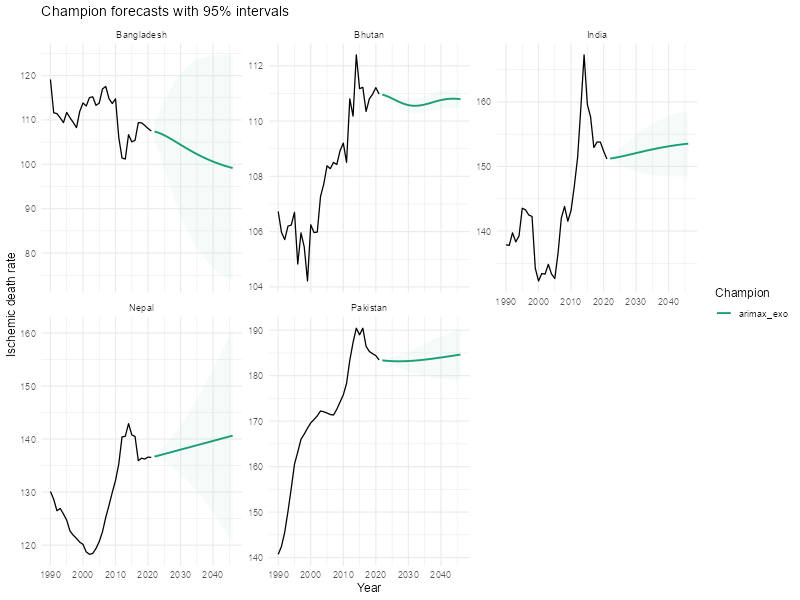

In [767]:
# Inputs: forecasts_tbl (country, year, model, point, lo95, hi95), all_exo (history)
stopifnot(all(c("country","year","model","point","lo95","hi95") %in% names(forecasts_tbl)))

actuals_all <- all_exo |> as_tibble()

p_forecasts <- ggplot() +
  geom_line(data = actuals_all,
            aes(x = year, y = Ischemic_DR),
            color = "black", linewidth = 0.6) +
  geom_ribbon(data = forecasts_tbl,
              aes(x = year, ymin = lo95, ymax = hi95, fill = model),
              alpha = 0.15) +
  geom_line(data = forecasts_tbl,
            aes(x = year, y = point, color = model),
            linewidth = 0.9) +
  facet_wrap(~ country, scales = "free_y") +
  scale_color_brewer(palette = "Dark2", name = "Champion") +
  scale_fill_brewer(palette = "Pastel2", guide = "none") +
  labs(title = "Champion forecasts with 95% intervals",
       x = "Year", y = "Ischemic death rate")

p_forecasts
ggsave("fig_forecasts_all.png", p_forecasts, width = 12, height = 8, dpi = 300,bg = "white")


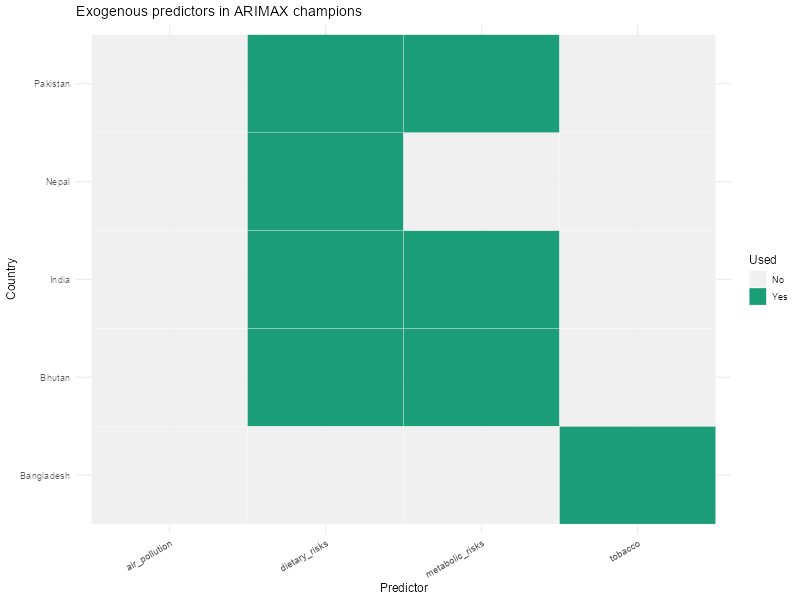

In [768]:
exo_vars <- c("air_pollution","dietary_risks","metabolic_risks","tobacco")

# Expand champion vars string (e.g., "dietary_risks + metabolic_risks") to long form
exo_map <- champions_updated |>
  mutate(vars = ifelse(exogenous, vars, "")) |>
  mutate(var_vec = strsplit(vars, " + ", fixed = TRUE)) |>
  select(country, exogenous, var_vec) |>
  tidyr::unnest_longer(var_vec, values_to = "var", keep_empty = TRUE) |>
  mutate(var = dplyr::na_if(var, ""), present = ifelse(!is.na(var), 1L, 0L)) |>
  # Ensure all exo columns appear even if unused
  tidyr::complete(country, var = exo_vars) |>
  mutate(present = ifelse(is.na(present), 0L, present))

p_heat <- ggplot(exo_map, aes(x = var, y = country, fill = factor(present))) +
  geom_tile(color = "white") +
  scale_fill_manual(values = c("0" = "#f0f0f0", "1" = "#1b9e77"), labels = c("No","Yes"), name = "Used") +
  labs(title = "Exogenous predictors in ARIMAX champions", x = "Predictor", y = "Country") +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

p_heat
ggsave("fig_exo_heatmap.png", p_heat, width = 7, height = 5, dpi = 300,bg = "white")


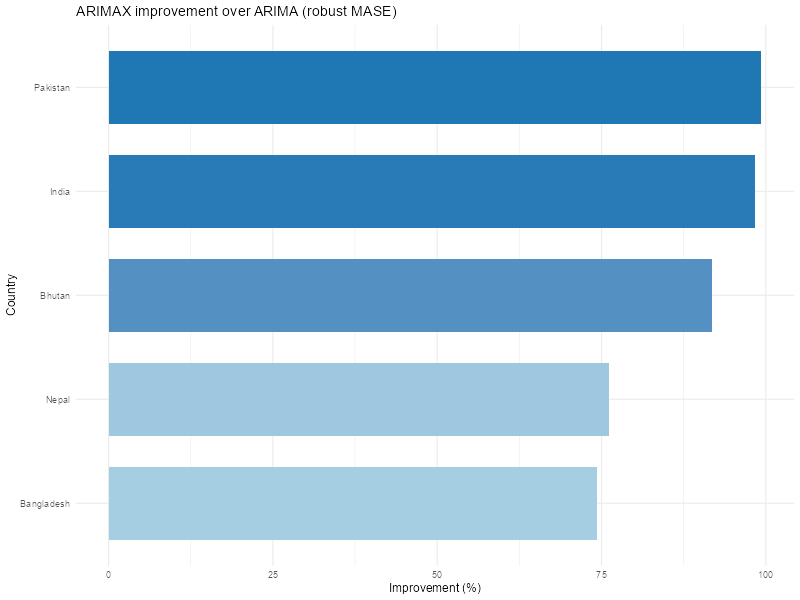

In [769]:
# grid_results contains per-country subset results, including improve_pct and pass
best_pass <- grid_results |>
  filter(pass) |>
  group_by(country) |>
  slice_min(order_by = MASE_robust, n = 1, with_ties = FALSE) |>
  ungroup()

p_improve <- ggplot(best_pass, aes(x = reorder(country, improve_pct), y = improve_pct, fill = improve_pct)) +
  geom_col(width = 0.7) +
  coord_flip() +
  scale_fill_gradient(low = "#a6cee3", high = "#1f78b4", guide = "none") +
  labs(title = "ARIMAX improvement over ARIMA (robust MASE)", x = "Country", y = "Improvement (%)")

p_improve
ggsave("fig_improvement.png", p_improve, width = 7, height = 5, dpi = 300,bg = "white")


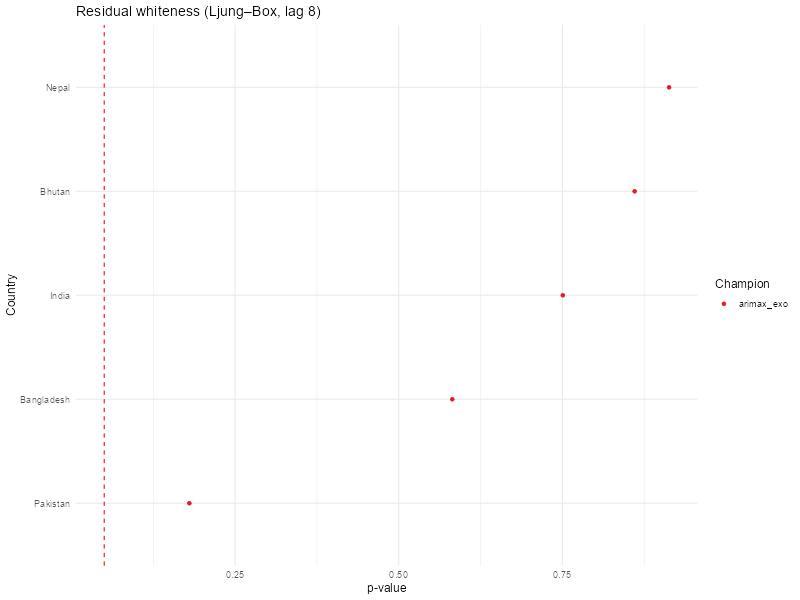

In [770]:
# For univariate champions
aug_uni <- fit_uni |>
  augment() |>
  as_tibble() |>
  inner_join(champions_updated |> filter(model_final %in% c("naive","drift","linear","ets","arima")),
             by = c("country", ".model" = "model_final"))

lb_uni <- aug_uni |>
  group_by(country, .model) |>
  summarise(
    lb_pvalue = {
      z <- .resid
      z <- z[is.finite(z)]
      if (length(z) < 3) NA_real_ else Box.test(z, lag = 8, type = "Ljung-Box", fitdf = 0)$p.value
    },
    .groups = "drop"
  )

# For ARIMAX champions (use p-values from the grid if available)
lb_exo <- best_pass |>
  transmute(country, .model = "arimax_exo", lb_pvalue)

lb_champs <- bind_rows(lb_uni, lb_exo) |>
  inner_join(champions_updated |> select(country, model_final),
             by = c("country", ".model" = "model_final"))

p_lb <- ggplot(lb_champs, aes(x = reorder(country, lb_pvalue), y = lb_pvalue, color = .model)) +
  geom_point(na.rm = TRUE) +
  geom_hline(yintercept = 0.05, linetype = "dashed", color = "red") +
  coord_flip() +
  scale_color_brewer(palette = "Set1", name = "Champion") +
  labs(title = "Residual whiteness (Ljung–Box, lag 8)", x = "Country", y = "p-value")

p_lb
ggsave("fig_champion_whiteness.png", p_lb, width = 7, height = 6, dpi = 300,bg = "white")


In [771]:
fan_tbl <- fc_all_final |>
  hilo(level = c(50, 80, 95)) |>
  as_tibble() |>
  transmute(
    country, year, .model,
    lo50 = `50%`$lower, hi50 = `50%`$upper,
    lo80 = `80%`$lower, hi80 = `80%`$upper,
    lo95 = `95%`$lower, hi95 = `95%`$upper,
    point = .mean
  )


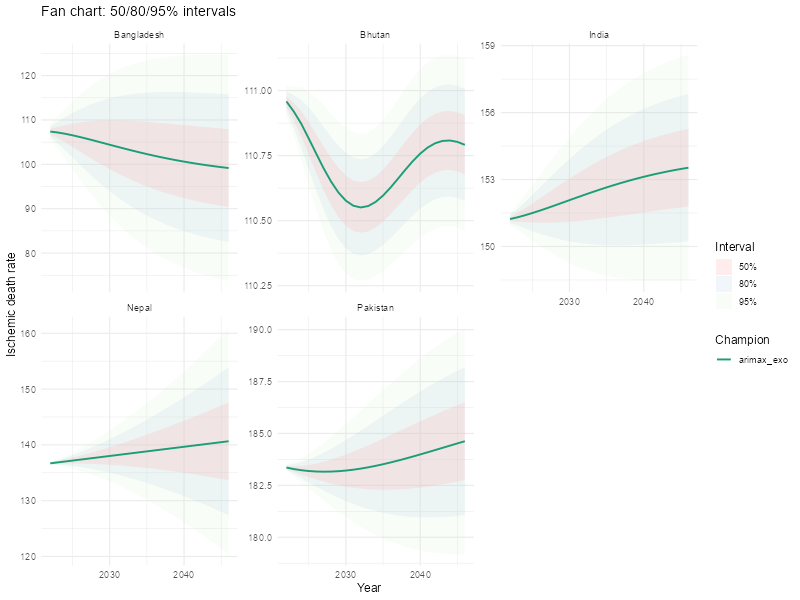

In [772]:
# Plot: 95 behind 80 behind 50 for a clean fan
p_fan <- ggplot(fan_tbl, aes(x = year)) +
  geom_ribbon(aes(ymin = lo95, ymax = hi95, fill = "95%"), alpha = 0.12) +
  geom_ribbon(aes(ymin = lo80, ymax = hi80, fill = "80%"), alpha = 0.18) +
  geom_ribbon(aes(ymin = lo50, ymax = hi50, fill = "50%"), alpha = 0.24) +
  geom_line(aes(y = point, color = .model), linewidth = 0.9) +
  facet_wrap(~ country, scales = "free_y") +
  scale_fill_brewer(palette = "Pastel1", name = "Interval") +
  scale_color_brewer(palette = "Dark2", name = "Champion") +
  labs(title = "Fan chart: 50/80/95% intervals", x = "Year", y = "Ischemic death rate")

p_fan
ggsave("fig_fan_chart.png", p_fan, width = 12, height = 8, dpi = 300,bg = "white")


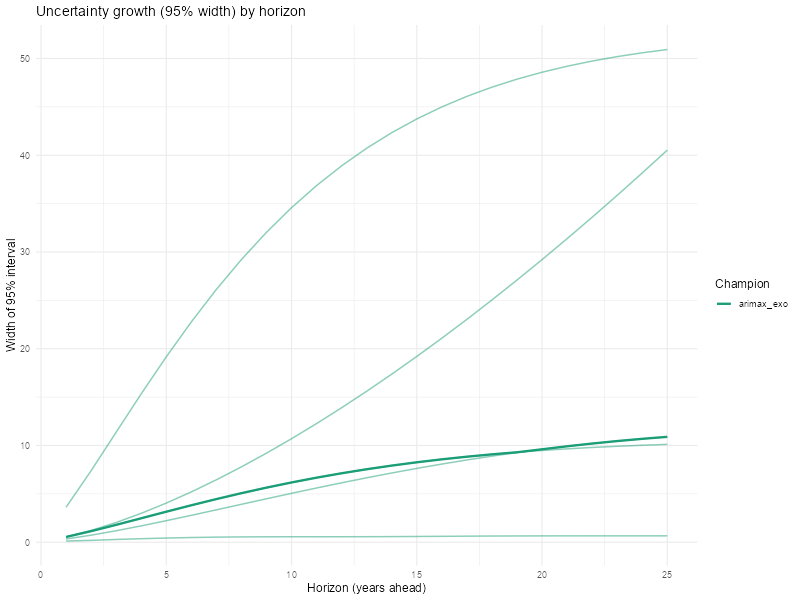

In [773]:
# Compute horizon index from the first forecast year per country
first_year <- fan_tbl |>
  group_by(country) |>
  summarise(first_fc = min(year), .groups = "drop")

unc_tbl <- fan_tbl |>
  left_join(first_year, by = "country") |>
  mutate(h = year - first_fc + 1L,
         width95 = hi95 - lo95,
         width80 = hi80 - lo80)

p_unc <- ggplot(unc_tbl, aes(x = h, y = width95, color = .model, group = country)) +
  geom_line(alpha = 0.5, linewidth = 0.7) +
  stat_summary(aes(group = .model), fun = median, geom = "line", linewidth = 1.1, linetype = "solid") +
  labs(title = "Uncertainty growth (95% width) by horizon",
       x = "Horizon (years ahead)", y = "Width of 95% interval") +
  scale_color_brewer(palette = "Dark2", name = "Champion")

p_unc
ggsave("fig_uncertainty_growth.png", p_unc, width = 8, height = 5, dpi = 300,bg = "white")


In [774]:
library(readr)
# forecasts_tbl assumed from earlier steps
# Columns: country, year, model, point, lo80, hi80, lo95, hi95
stopifnot(all(c("country","year","model","point","lo80","hi80","lo95","hi95") %in% names(forecasts_tbl)))

write_csv(forecasts_tbl, "tbl_forecasts_10y.csv")


In [775]:
library(dplyr)

# champions: holdout metrics for univariate stage (MASE_robust, RMSE, MAE) per country
# champions_updated: final (country, model_final, exogenous, vars)

model_card <- champions |>
  filter(label == "champion") |>
  select(country, MASE_robust, RMSE, MAE) |>
  right_join(champions_updated, by = "country") |>
  transmute(
    country,
    model_final,
    exogenous = ifelse(exogenous, "yes", "no"),
    exo_vars  = ifelse(exogenous, vars, NA_character_),
    MASE_robust = round(MASE_robust, 3),
    RMSE        = round(RMSE, 3),
    MAE         = round(MAE, 3)
  ) |>
  arrange(country)

readr::write_csv(model_card, "tbl_model_card.csv")


In [776]:
# grid_results holding (country, vars, MASE_robust, RMSE, MAE, lb_pvalue, improve_pct, pass)

exo_best <- grid_results |>
  group_by(country) |>
  # Keep the top passing subset; if none pass, keep the best overall and mark pass = FALSE
  arrange(!pass, MASE_robust, RMSE, MAE, .by_group = TRUE) |>
  slice_head(n = 1) |>
  ungroup() |>
  transmute(
    country,
    exo_vars   = ifelse(pass, vars, NA_character_),
    exo_pass   = ifelse(pass, "yes", "no"),
    exo_MASE   = round(MASE_robust, 3),
    exo_RMSE   = round(RMSE, 3),
    exo_MAE    = round(MAE, 3),
    lb_pvalue  = round(lb_pvalue, 3),
    improve_pct = round(improve_pct, 1)
  )

readr::write_csv(exo_best, "tbl_exogenous_selection.csv")


In [777]:
library(dplyr)
library(tidyr)

# Determine first forecast year per country
first_fc <- forecasts_tbl |>
  group_by(country) |>
  summarise(y0 = min(year), .groups = "drop")

# Tag horizons and keep H=1,5,10
fc_h <- forecasts_tbl |>
  left_join(first_fc, by = "country") |>
  mutate(h = year - y0 + 1L) |>
  filter(h %in% c(1L, 5L, 10L)) |>
  mutate(h = paste0("H", h))

# Pivot to wide for compact per-country summary
fc_summary <- fc_h |>
  select(country, h, point, lo95, hi95) |>
  pivot_longer(cols = c(point, lo95, hi95), names_to = "stat", values_to = "value") |>
  unite(col = "col", h, stat) |>
  pivot_wider(names_from = col, values_from = value) |>
  arrange(country)

readr::write_csv(fc_summary, "tbl_forecast_summary_H1_H5_H10.csv")


In [778]:
# Series length and test size
series_meta <- all_exo |>
  as_tibble() |>
  group_by(country) |>
  summarise(
    n_obs = n(),
    first_year = min(year),
    last_year  = max(year),
    .groups = "drop"
  )

# Test window size (k years)
test_meta <- test |>
  as_tibble() |>
  count(country, name = "test_n")

methods_tbl <- series_meta |>
  left_join(test_meta, by = "country") |>
  left_join(champions_updated |> select(country, model_final, exogenous), by = "country") |>
  arrange(country)

readr::write_csv(methods_tbl, "tbl_methods_meta.csv")
